Assignment 4 - Socioeconomic analysis
===

*Due: January 17 2023*

You will analyze a set of movies dialogues and calculate their sentiment scores (using Vader, text Blob, or Naive Bayes).

Then you will analyze how the positivity (or negativity) of sentiment score expressed in movie dialogues changes through time and is affected by socioeconomic and historical events.

In particular, you will use the provided R scripts to test how sentiment scores in movies are affected by GDP per capita, Life expectancy and the political cycle (Republican or Democrat president).

## Import

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import nltk
import os

# Download if necessary
try:
    os.path.exists("~/nltk_data/")
except:
    nltk.download("all")

In [3]:
import pandas as pd
import regex as re
import contractions
from textblob import TextBlob
from glob import glob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy import stats
import numpy as np


lemma = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))
lang = "eng"
data_path = "data/dialogs_preprocessed2/"

## Functions

### Functions for text preprocessing

In [4]:
def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    output = re.sub(r"[^a-zA-Z0-9]", " ", input)
    return output


def clean_tokenization(input):
    output = nltk.word_tokenize(input)
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [p.number_to_words(item)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization(input):
    output = [lemma.lemmatize(word=w, pos="v") for w in input]
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def preprocessing(text, remove_stopwords=True):
    """
    Preprocessing pipeline.
    """
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization(text)
    text = numbers_to_words(text)
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

## Load movie dialogs and preprocess them

In [5]:
df = pd.DataFrame(glob(data_path + "/*.txt"), columns=["movies"])
df["path"] = df["movies"]
df["movies"] = df["movies"].str.replace("^" + data_path, "", regex=True)


df["text"] = df["path"].apply(lambda path: open(path, encoding="utf-8").read())
df["text"] = df["text"].apply(lambda raw_txt: preprocessing(raw_txt))

df.head()

,movies,path,text
0,truegrit_dialog.txt,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...
1,ghost_dialog.txt,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...
2,dropdeadgorgeous_dialog.txt,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...
3,megamind_dialog.txt,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...
4,thisis40_dialog.txt,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...


Add column for movie years

In [6]:
df_years = pd.read_csv("data/movie_years.csv", index_col=0)
df = df.merge(df_years, on="movies")

df.movies = df.movies.str.replace("_dialog.txt$", "", regex=True)

## Add sentiment scores

In [7]:
df["textblob"] = df.text.apply(lambda x: TextBlob(x).sentiment.polarity)

df.head()

,movies,path,text,year,textblob
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...,2010,0.073045
1,ghost,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...,1990,0.089542
2,dropdeadgorgeous,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...,1999,0.147764
3,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...,2010,0.103158
4,thisis40,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...,2012,0.109904


Save dataframe

In [8]:
df.to_csv("data/assignment_4_sentiment_scores.csv", index=False)

Load dataframe

In [137]:
df = pd.read_csv("data/assignment_4_sentiment_scores.csv")

df.head()

,movies,path,text,year,textblob
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...,2010,0.073045
1,ghost,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...,1990,0.089542
2,dropdeadgorgeous,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...,1999,0.147764
3,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...,2010,0.103158
4,thisis40,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...,2012,0.109904


## Time series

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


df_clean = df.copy().dropna()

reg = linregress(df_clean.year, df_clean.textblob)

print("Regression result:\n")
print("intercept:", reg.intercept)
print("slope:", reg.slope)
print("p:", reg.pvalue)

Regression result:

intercept: 1.2071145932778309
slope: -0.0005662637149927922
p: 0.00031429903489513277


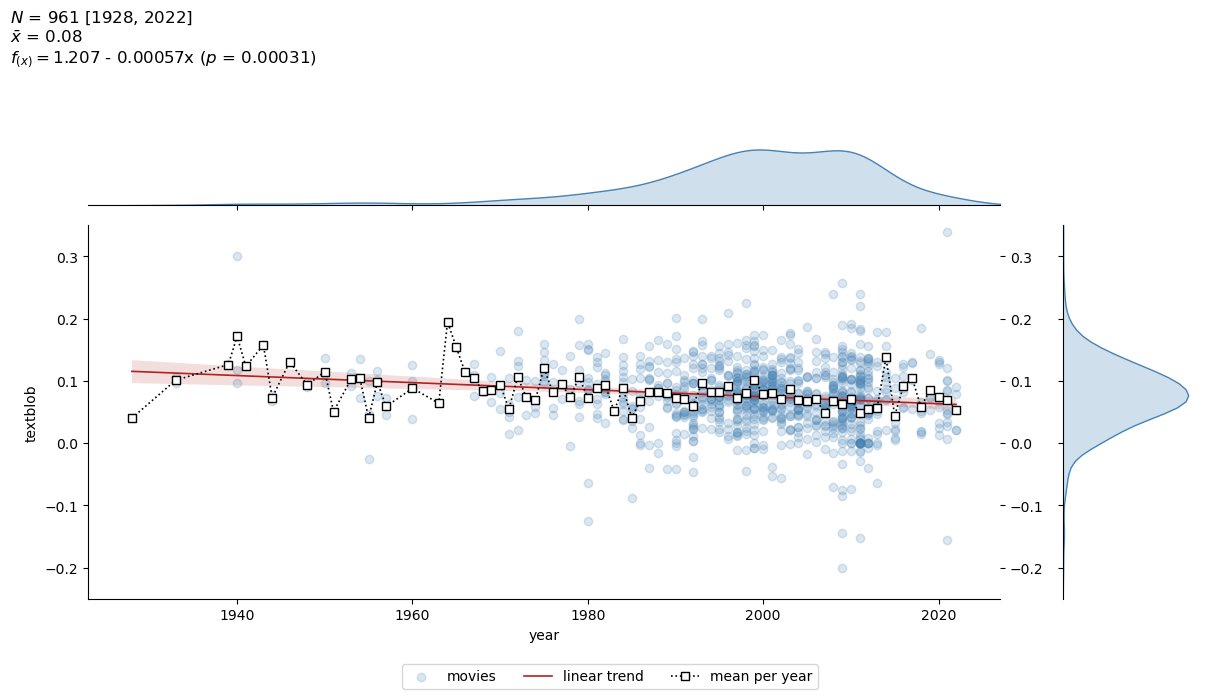

In [139]:
title = (
    f"$N$ = {len(df_clean)} [{min(df_clean.year)}, {max(df_clean.year)}]"
    + "\n"
    + r"$\bar{x}$ = "
    + f"{df_clean.textblob.mean():.2f}"
    + "\n"
    + r"$f_{(x)} = $"
    + f"{reg.intercept:.3f} {'+' if reg.slope > 0 else '-'} {abs(reg.slope):.2g}x"
    + " ($p$ = "
    + f"{reg.pvalue:.2g})"
)

g = sns.JointGrid(
    x=df_clean.year,
    y=df_clean.textblob,
    ylim=(-0.25, 0.35),
    xlim=(-5 + min(df_clean.year), 5 + max(df_clean.year)),
)

regplot = g.plot_joint(
    sns.regplot,
    scatter_kws=dict(alpha=0.2, color="steelblue"),
    line_kws=dict(color="firebrick", lw=1.2, label="linear trend", linestyle="-"),
    label="movies",
)

g.plot_marginals(sns.kdeplot, fill=True, color="steelblue")
# g.ax_marg_y.set_visible(False)

g.fig.figure.set_figheight(6)
g.fig.figure.set_figwidth(12)


lplot = sns.lineplot(
    df_clean.groupby("year").mean()["textblob"],
    lw=1.2,
    linestyle=":",
    marker="s",
    markersize=6,
    markeredgecolor="black",
    color="black",
    markeredgewidth=1,
    markerfacecolor="white",
    ax=g.ax_joint,
    label="mean per year",
    legend=False,
)
g.ax_joint.tick_params(right=True, labelright=True, grid_color="black")
g.fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
g.fig.suptitle(
    title,
    x=0,
    fontsize=12,
    verticalalignment="bottom",
    horizontalalignment="left",
)
g.fig.tight_layout()

<div class="alert alert-info">Significant probably only because of the large number of datapoints. Is the effect actually relevant?</div>

## Influence of socioeconomic and historical events

In particular, you will use the provided R scripts to test how sentiment scores in movies are affected by GDP per capita, Life expectancy and the political cycle (Republican or Democrat president).

In [142]:
df = df[["movies", "year", "textblob"]]
df.head()

,movies,year,textblob
0,truegrit,2010,0.073045
1,ghost,1990,0.089542
2,dropdeadgorgeous,1999,0.147764
3,megamind,2010,0.103158
4,thisis40,2012,0.109904


### Load socioeconomic data

and filter on United States

In [143]:
df_lifeexp = pd.read_csv("data/life-expectancy.csv").rename(
    columns={"Year": "year", "Life expectancy at birth (historical)": "life_expectancy"}
)
df_lifeexp = df_lifeexp.loc[df_lifeexp.Code == "USA"].reset_index(drop=True)[
    ["year", "life_expectancy"]
]

df_lifeexp.tail()

,year,life_expectancy
118,2017,78.8
119,2018,79.0
120,2019,79.1
121,2020,77.4
122,2021,77.2


In [144]:
df_pres = (
    pd.read_csv("data/US_presidents.csv")
    .rename(columns={"Years (after inauguration)": "year"})[["year", "Party"]]
    .rename(columns={"Party": "president"})
)

df_pres.tail()

,year,president
222,2009,Democrat
223,2010,Democrat
224,2011,Democrat
225,2012,Democrat
226,2013,Democrat


In [145]:
df_gdp = pd.read_csv("data/GDPperCapita_Compact.csv")
df_gdp = (
    df_gdp.loc[df_gdp["country name"] == "United States"]
    .drop(["ccode", "country name"], axis=1)
    .T.reset_index()
    .rename(columns={"index": "year", 156: "GDPpc"})
)
df_gdp.year = df_gdp.year.astype(int)
df_gdp = df_gdp.dropna().reset_index(drop=True)
df_gdp.tail()

,year,GDPpc
215,2012,50394.0
216,2013,50863.0
217,2014,51664.0
218,2015,52591.0
219,2016,53015.0


Keep only rows with no missing values

In [146]:
df_socec = df_gdp.merge(df_pres, on="year", how="inner").merge(
    df_lifeexp, on="year", how="inner"
)

# categorical variable dummy variable
df_socec = df_socec.merge(
    pd.get_dummies(df_socec.president), left_index=True, right_index=True
).drop("president", axis=1)

df_socec.tail()

,year,GDPpc,life_expectancy,Democrat,Republican
110,2009,48452.9335,78.6,1,0
111,2010,49266.9159,78.8,1,0
112,2011,49675.0000,78.8,1,0
113,2012,50394.0000,78.9,1,0
114,2013,50863.0000,79.0,1,0


### Add socioeconomic variables to main dataframe

In [147]:
df = df.merge(df_socec, on="year", validate="m:1")

### Compute z-scores for economic variables

In [148]:
df["z_GDPpc"] = stats.zscore(df["GDPpc"], nan_policy="omit")
df["z_life_expectancy"] = stats.zscore(df["life_expectancy"], nan_policy="omit")

### Compute z-scores for textblob

In [150]:
df["z_textblob"] = stats.zscore(df["textblob"], nan_policy="omit")

Save dataframe

In [151]:
df.to_csv("data/3.1_output_complete_dataset.csv", index=False)

Load dataframe

In [152]:
df = pd.read_csv("data/3.1_output_complete_dataset.csv")

### Aggregate by year (mean, count)

In [153]:
df_year = df.groupby("year", as_index=False).mean()
df_year.head()

,year,textblob,GDPpc,life_expectancy,Democrat,Republican,z_GDPpc,z_life_expectancy,z_textblob
0,1928,0.040215,11451.069,58.30,0.0,1.0,-3.395303,-6.659607,-0.487753
1,1933,0.101128,8048.225,60.88,1.0,0.0,-3.776070,-5.704131,0.363121
2,1939,0.126217,11171.448,63.07,1.0,0.0,-3.426592,-4.893087,0.713590
3,1940,0.171566,12005.095,63.23,1.0,0.0,-3.333310,-4.833833,1.347057
4,1941,0.123213,13553.402,63.80,1.0,0.0,-3.160059,-4.622739,0.671623


Add count

In [154]:
df_year_count = df_year.fillna(0).groupby("year", as_index=False).count().iloc[:, :2]
df_year_count.columns = ["year", "text_per_year"]
df_year = df_year.merge(df_year_count, on="year")

Save Dataframe

In [155]:
df_year.to_csv("data/3.2_output_complete_data_by_year.csv", index=False)

Load dataframe

In [156]:
df_year = pd.read_csv("data/3.2_output_complete_data_by_year.csv")

### Add time lags

In [157]:
df_year_lags = df_year.copy()

lag_vars = list(df_gdp.columns)
year = list(df_gdp["year"][1:])
# print(SOC_ECON_data)

## this loop takes each socioeconomic variable
for var in lag_vars:
    var_list = list(df_gdp[var][1:])
    dictionary_var = dict(zip(year, var_list))

    ## and creates the lags within T-20 and T+20
    for lag in range(-20, 21):
        var_lag_list = []

        ## for each row we find what the lagged year would be
        for index1, row in df_year_lags.iterrows():
            yr_df = row["year"] + lag
            # print(yr_df)
            try:
                ##and find what the socioeconomic value was in the lagged year
                var1 = dictionary_var[yr_df]
                var_lag_list += [var1]
            except KeyError:
                var_lag_list += [np.nan]

        # print(GDP_lag_list)
        df_year_lags[var + str(lag)] = var_lag_list

df_year_lags.head()

,year,textblob,GDPpc,life_expectancy,Democrat,Republican,z_GDPpc,z_life_expectancy,z_textblob,text_per_year,...,GDPpc11,GDPpc12,GDPpc13,GDPpc14,GDPpc15,GDPpc16,GDPpc17,GDPpc18,GDPpc19,GDPpc20
0,1928,0.040215,11451.069,58.30,0.0,1.0,-3.395303,-6.659607,-0.487753,1,...,11171.448,12005.095,13553.4020,14869.8610,16050.217,16999.327,16477.552,14822.4665,14311.5472,14734.232
1,1933,0.101128,8048.225,60.88,1.0,0.0,-3.776070,-5.704131,0.363121,1,...,16999.327,16477.552,14822.4665,14311.5472,14734.232,14196.672,15240.000,16125.0000,16444.0000,16917.000
2,1939,0.126217,11171.448,63.07,1.0,0.0,-3.426592,-4.893087,0.713590,1,...,15240.000,16125.000,16444.0000,16917.0000,16512.000,17370.000,17397.000,17406.0000,16946.0000,17900.000
3,1940,0.171566,12005.095,63.23,1.0,0.0,-3.333310,-4.833833,1.347057,1,...,16125.000,16444.000,16917.0000,16512.0000,17370.000,17397.000,17406.000,16946.0000,17900.0000,18057.000
4,1941,0.123213,13553.402,63.80,1.0,0.0,-3.160059,-4.622739,0.671623,1,...,16444.000,16917.000,16512.0000,17370.0000,17397.000,17406.000,16946.000,17900.0000,18057.0000,18175.000


Save Dataframe

In [158]:
df_year_lags.to_csv("data/3.3_output_complete_data_lags.csv", index=False)

Load dataframe

In [159]:
df_year_lags = pd.read_csv("data/3.3_output_complete_data_lags.csv")

## Economic correlations

In [173]:
# df = pd.read_csv("data/3.1_output_complete_dataset.csv")


# interesting columns
cols = [
    "z_textblob",
    "z_GDPpc",
    "z_life_expectancy",
    "Republican",
]

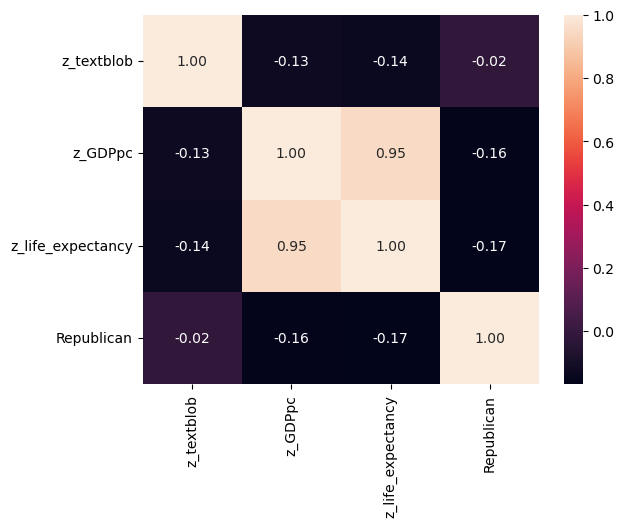

In [198]:
from scipy.stats import pearsonr


def get_corr_mats(df, cols):
    df = df[cols]
    coeffmat = np.zeros((len(cols), len(cols)))
    pvalmat = np.zeros((len(cols), len(cols)))

    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            corrtest = pearsonr(df[col1], df[col2])
            coeffmat[i, j] = corrtest[0]
            pvalmat[i, j] = corrtest[1]

    dfcoeff = pd.DataFrame(coeffmat, columns=df.columns, index=df.columns)
    dfpvals = pd.DataFrame(pvalmat, columns=df.columns, index=df.columns)

    return dfcoeff, dfpvals


df_coeff, df_pvals = get_corr_mats(df, cols)

cormat = df[cols].corr(method="pearson")

sns.heatmap(cormat, annot=True, fmt=".2f");

In [197]:
df_coeff.round(2)

,z_textblob,z_GDPpc,z_life_expectancy,Republican
z_textblob,1.00,-0.13,-0.14,-0.02
z_GDPpc,-0.13,1.00,0.95,-0.16
z_life_expectancy,-0.14,0.95,1.00,-0.17
Republican,-0.02,-0.16,-0.17,1.00


In [194]:
df_pvals.round(4)

,z_textblob,z_GDPpc,z_life_expectancy,Republican
z_textblob,0.0000,0.0001,0.0,0.6028
z_GDPpc,0.0001,0.0000,0.0,0.0000
z_life_expectancy,0.0000,0.0000,0.0,0.0000
Republican,0.6028,0.0000,0.0,0.0000


## Lag analysis


In [199]:
import statsmodels.api as sm
from sklearn import preprocessing


## Initialize  all variables and transform them
df_year_lags["year2"] = df_year_lags["year"]
df_year_lags["year"] = preprocessing.scale(df_year_lags["year"])
df_year_lags["GDP"] = preprocessing.scale(df_year_lags["GDPpc"])
df_year_lags["GDPm1"] = preprocessing.scale(df_year_lags["GDPpc1"])
df_year_lags["GDPm2"] = preprocessing.scale(df_year_lags["GDPpc2"])
df_year_lags["GDPm3"] = preprocessing.scale(df_year_lags["GDPpc3"])
df_year_lags["GDPm4"] = preprocessing.scale(df_year_lags["GDPpc4"])
df_year_lags["GDPm5"] = preprocessing.scale(df_year_lags["GDPpc5"])
df_year_lags["GDPm6"] = preprocessing.scale(df_year_lags["GDPpc6"])
df_year_lags["GDPm7"] = preprocessing.scale(df_year_lags["GDPpc7"])
df_year_lags["GDPm8"] = preprocessing.scale(df_year_lags["GDPpc8"])
df_year_lags["GDPm9"] = preprocessing.scale(df_year_lags["GDPpc9"])
df_year_lags["GDPm10"] = preprocessing.scale(df_year_lags["GDPpc10"])
df_year_lags["GDPm11"] = preprocessing.scale(df_year_lags["GDPpc11"])
df_year_lags["GDPm12"] = preprocessing.scale(df_year_lags["GDPpc12"])
df_year_lags["GDPm13"] = preprocessing.scale(df_year_lags["GDPpc13"])
df_year_lags["GDPm14"] = preprocessing.scale(df_year_lags["GDPpc14"])
df_year_lags["GDPm15"] = preprocessing.scale(df_year_lags["GDPpc15"])
df_year_lags["GDPm16"] = preprocessing.scale(df_year_lags["GDPpc16"])
df_year_lags["GDPm17"] = preprocessing.scale(df_year_lags["GDPpc17"])
df_year_lags["GDPm18"] = preprocessing.scale(df_year_lags["GDPpc18"])
df_year_lags["GDPm19"] = preprocessing.scale(df_year_lags["GDPpc19"])
df_year_lags["GDPm20"] = preprocessing.scale(df_year_lags["GDPpc20"])
df_year_lags["GDPp1"] = preprocessing.scale(df_year_lags["GDPpc1"])
df_year_lags["GDPp2"] = preprocessing.scale(df_year_lags["GDPpc2"])
df_year_lags["GDPp3"] = preprocessing.scale(df_year_lags["GDPpc3"])
df_year_lags["GDPp4"] = preprocessing.scale(df_year_lags["GDPpc4"])
df_year_lags["GDPp5"] = preprocessing.scale(df_year_lags["GDPpc5"])
df_year_lags["GDPp6"] = preprocessing.scale(df_year_lags["GDPpc6"])
df_year_lags["GDPp7"] = preprocessing.scale(df_year_lags["GDPpc7"])
df_year_lags["GDPp8"] = preprocessing.scale(df_year_lags["GDPpc8"])
df_year_lags["GDPp9"] = preprocessing.scale(df_year_lags["GDPpc9"])
df_year_lags["GDPp10"] = preprocessing.scale(df_year_lags["GDPpc10"])
df_year_lags["GDPp11"] = preprocessing.scale(df_year_lags["GDPpc11"])
df_year_lags["GDPp12"] = preprocessing.scale(df_year_lags["GDPpc12"])
df_year_lags["GDPp13"] = preprocessing.scale(df_year_lags["GDPpc13"])
df_year_lags["GDPp14"] = preprocessing.scale(df_year_lags["GDPpc14"])
df_year_lags["GDPp15"] = preprocessing.scale(df_year_lags["GDPpc15"])
df_year_lags["GDPp16"] = preprocessing.scale(df_year_lags["GDPpc16"])
df_year_lags["GDPp17"] = preprocessing.scale(df_year_lags["GDPpc17"])
df_year_lags["GDPp18"] = preprocessing.scale(df_year_lags["GDPpc18"])
df_year_lags["GDPp19"] = preprocessing.scale(df_year_lags["GDPpc19"])
df_year_lags["GDPp20"] = preprocessing.scale(df_year_lags["GDPpc20"])


df_year_lags = df_year_lags.dropna()

Boxcox transformation

In [200]:
#
#
#

Model controlling for autocorrelation in the time dimension

In [202]:
from statsmodels.formula.api import gls, ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

formula = "z_textblob ~ year + GDP + GDPm5 + GDPp5 + GDPm10 + GDPp10 + GDPm15 + GDPp15 + GDPm20 + GDPp20 + GDPm1 + GDPp1 + GDPm6 + GDPp6 + GDPm11 + GDPp11 + GDPm16 + GDPp16 + GDPm2 + GDPp2 + GDPm7 + GDPp7 + GDPm12 + GDPp12 + GDPm17 + GDPp17 + GDPm3 + GDPp3 + GDPm8 + GDPp8 + GDPm13 + GDPp13 + GDPm18 + GDPp18 + GDPm4 + GDPp4 + GDPm9 + GDPp9 + GDPm14 + GDPp14 + GDPm19 + GDPp19"

full_model_sentiment_GDP = gls(
    formula,
    data=df_year_lags,
)

best_model_sentiment_GDP = sm.regression.linear_model.RegressionResultsWrapper(
    ols(formula, df_year_lags).fit()
)

res_best_model_sentiment_GDP = best_model_sentiment_GDP.resid
shapiro_test = shapiro(res_best_model_sentiment_GDP)


best_model_sentiment_GDP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             z_textblob   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.186
Date:                Sat, 21 Jan 2023   Prob (F-statistic):              0.331
Time:                        18:36:48   Log-Likelihood:                -14.005
No. Observations:                  51   AIC:                             74.01
Df Residuals:                      28   BIC:                             118.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7487      0.375      1.996      0.056      -0.020       1.517
year           0.6206      0.693      0.895      0.378      -0.799       2.041
GDP           -0.8513      1.649     -0.516      0.610      -4.229       2.526
GDPm5          0.1398      1.132      0.124      0.903      -2.178       2.458
GDPp5          0.1398      1.132      0.124      0.903      -2.178       2.458
GDPm10         0.7563      1.219      0.621      0.540      -1.740       3.253
GDPp10         0.7563      1.219      0.621      0.540      -1.740       3.253
GDPm15        -0.1970      1.014     -0.194      0.847      -2.273       1.879
GDPp15        -0.1970      1.014     -0.194      0.847      -2.273       1.879
GDPm20        -0.3011      0.655     -0.460      0.649      -1.642       1.040
GDPp20        -0.3011      0.655     -0.460      0.649      -1.642       1.040
GDPm1         -0.0050      1.132     -0.004      0.996      -2.324       2.314
GDPp1         -0.0050      1.132     -0.004      0.996      -2.324       2.314
GDPm6         -0.0209      1.260     -0.017      0.987      -2.602       2.560
GDPp6         -0.0209      1.260     -0.017      0.987      -2.602       2.560
GDPm11        -1.2738      1.295     -0.984      0.334      -3.926       1.378
GDPp11        -1.2738      1.295     -0.984      0.334      -3.926       1.378
GDPm16        -1.0370      1.042     -0.995      0.328      -3.171       1.097
GDPp16        -1.0370      1.042     -0.995      0.328      -3.171       1.097
GDPm2          0.7325      1.173      0.624      0.537      -1.671       3.136
GDPp2          0.7325      1.173      0.624      0.537      -1.671       3.136
GDPm7         -0.1768      1.265     -0.140      0.890      -2.767       2.414
GDPp7         -0.1768      1.265     -0.140      0.890      -2.767       2.414
GDPm12         0.5611      1.206      0.465      0.645      -1.909       3.031
GDPp12         0.5611      1.206      0.465      0.645      -1.909       3.031
GDPm17         1.3755      1.085      1.268      0.215      -0.846       3.597
GDPp17         1.3755      1.085      1.268      0.215      -0.846       3.597
GDPm3         -0.3910      1.133     -0.345      0.733      -2.712       1.930
GDPp3         -0.3910      1.133     -0.345      0.733      -2.712       1.930
GDPm8          0.1608      1.155      0.139      0.890      -2.205       2.526
GDPp8          0.1608      1.155      0.139      0.890      -2.205       2.526
GDPm13        -0.1611      1.033     -0.156      0.877      -2.277       1.955
GDPp13        -0.1611      1.033     -0.156      0.877      -2.277       1.955
GDPm18        -2.1290      1.097     -1.940      0.063      -4.377       0.119
GDPp18        -2.1290      1.097     -1.940      0.063      -4.377       0.119
GDPm4          0.5198      1.132      0.459      0.650      -1.798       2.838
GD

Plot diagnostics

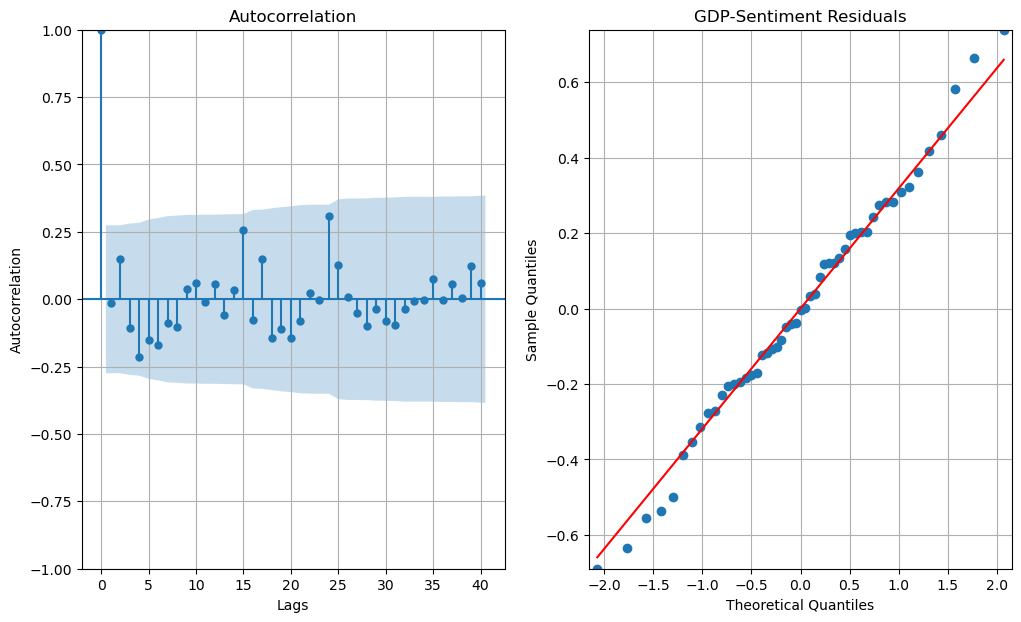

In [203]:
from statsmodels.graphics.gofplots import qqplot

fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# plot 1
axs[0].set_title("GDP-Sentiment residual autocorrelation")
axs[0].set_xlabel("Lags")
axs[0].set_ylabel("Autocorrelation")
axs[0].grid(visible=True)
axs[0].autoscale(tight=True)
sm.graphics.tsa.plot_acf(res_best_model_sentiment_GDP, lags=40, ax=axs[0])

# plot 2
axs[1].set_title("GDP-Sentiment Residuals")
axs[1].grid(visible=True)
axs[1].autoscale(tight=True)

qqplot(res_best_model_sentiment_GDP, line="s", ax=axs[1])

fig.savefig("fig_lags_diagnostics.png")

<div class="alert alert-warning">This is a simple first implementation, R² is .48</div>